# Window transformer demo
A noteboook to briefly illustrate the main functionanlities and API calls to time series transformations based on moving window. <br>
There are two options for applying window transformation: either to use the builtin functions or to provide a function that will be applied on a moving window on the time series. <br>
The builtins are divided into two groups: 
* A window based group: where the user has to provide the window size. The functions in this group are the following 
"count", "sum", "mean", "median", "min", "max", "std", "var", "skew", "kurt", "corr", "cov", "quantile", "sem", "rank". They are based on [pandas.DataFrame.rolling](https://pandas.pydata.org/docs/reference/window.html#api-functions-rolling).
* An exponentially-weighted window group: the user needs to specify how to decay the weights of observations in the times series that are being "reduced" together. The functions in this group are the following "ewm_mean", "ewm_var", "ewm_std", "ewm_corr", "ewm_cov", "ewm_sum", "ewm_skew". They are based on [pandas.DataFrame.ewm](https://pandas.pydata.org/docs/reference/window.html#exponentially-weighted-window-functions)

The use provided function is also a applied using [pandas.DataFrame.rolling.apply](https://pandas.pydata.org/docs/reference/api/pandas.core.window.rolling.Rolling.apply.html#pandas.core.window.rolling.Rolling.apply) which required providing a window size. 

## Calling window_transform( ) on TimeSeries object

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.utils.timeseries_generation import linear_timeseries as lt
from darts.datasets import AirPassengersDataset

univ_series = AirPassengersDataset().load()
print(
    "univariate series shape:",
    univ_series._xa.shape,
    " component names:",
    list(univ_series.components),
)
multi_series = univ_series.stack(univ_series + 200)
print(
    "multivariate series shape:",
    multi_series._xa.shape,
    " component names:",
    list(multi_series.components),
)
stochastic_series = multi_series.stack(
    multi_series + 200, axis=2
)  # I added this axis to easily create stochatic series
print(
    "stochastic series shape:",
    stochastic_series._xa.shape,
    " component names:",
    list(stochastic_series.components),
)

univariate series shape: (144, 1, 1)  component names: ['#Passengers']
multivariate series shape: (144, 2, 1)  component names: ['#Passengers', '#Passengers_1']
stochastic series shape: (144, 2, 2)  component names: ['#Passengers', '#Passengers_1']


### Multivariate series transformation

When we don't specify which transformation to be applied on which component, all components 
are transformed with the same function. <br>
I added a user warning to let the user know what is happening with NA. Default for NA is to drop them. 

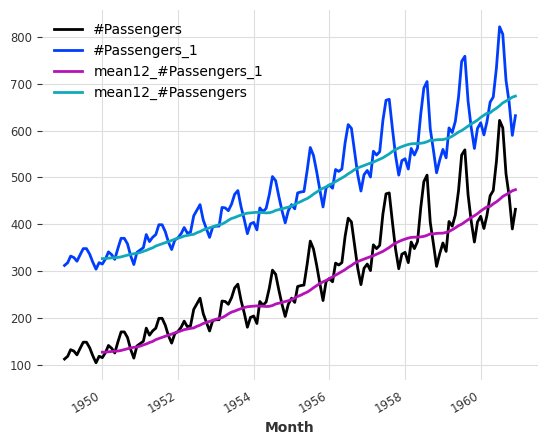

In [2]:
window_transf_dict = {"function": "mean", "window": 12}

transformed_m_series = multi_series.window_transform(
    window_transformations=window_transf_dict
)

multi_series.plot()
transformed_m_series.plot()

### Multiple transformation functions
Multiple transformations are provided in a list. Similarly, if not specified all transformations are applied to all components. 

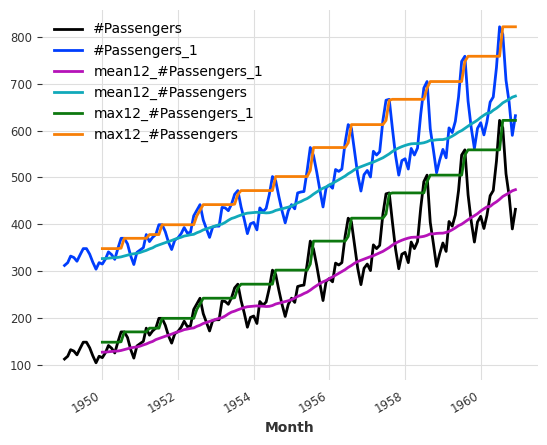

In [3]:
window_transf_dict = [
    {"function": "mean", "window": 12},
    {"function": "max", "window": 12},
]

transformed_m_series = multi_series.window_transform(
    window_transformations=window_transf_dict
)

multi_series.plot()
transformed_m_series.plot()

### Specifiying components to transform
To specify components to transform, the user can add the 'components' key to the transformation dictionary. 
The value for this key is a list (or one string) of components names on which to apply the transformation. 

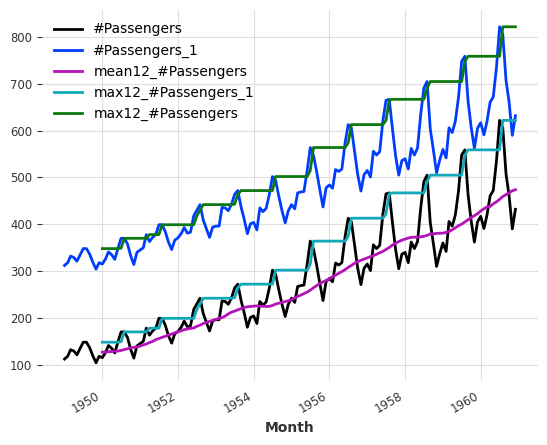

In [4]:
window_transf_dict = [
    {"function": "mean", "window": 12, "components": "#Passengers"},
    {"function": "max", "window": 12, "components": ["#Passengers", "#Passengers_1"]},
]

transformed_m_series = multi_series.window_transform(
    window_transformations=window_transf_dict
)

multi_series.plot()
transformed_m_series.plot()

### Deciding on the returned components after transformation
The users can decide if they want to return only the transformed components or to return the transformed components along the non-transformed ones. The original versions of the transformed components are not returned. <br>
The argument 'keep_non_transformed' in TimeSeries.window_transform can be set to select one of the two options. It defaults not to return the non transformed. 

Only transformed components output shape: (132, 1, 1)


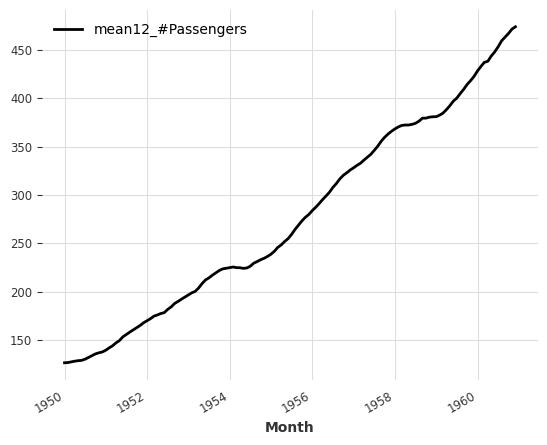

In [10]:
window_transf_dict = [{"function": "mean", "window": 12, "components": "#Passengers"}]

onlytransformed_m_series = multi_series.window_transform(
    window_transformations=window_transf_dict, keep_non_transformed=False
)

onlytransformed_m_series.plot()
print("Only transformed components output shape:", onlytransformed_m_serie._xa.shape)

Transformed and non transformed components output shape: (132, 2, 1)


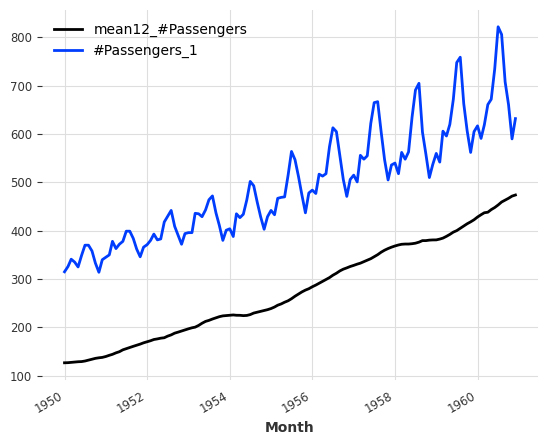

In [11]:
transformedAndNontransformed_m_series = multi_series.window_transform(
    window_transformations=window_transf_dict, keep_non_transformed=True
)

transformedAndNontransformed_m_series.plot(new_plot=True)
print(
    "Transformed and non transformed components output shape:",
    transformedAndNontransformed_m_serie._xa.shape,
)

### Stochastic series
All samples in a stochastic series are transformed in the same manner, there is no option to select different transformations for different samples of a given component. All the previous remains valid and applies in a similar fashion to samples of different components. <br>
A user warning appears because the uderlying series is stochastic and it is being transformed into a dataframe, with samples on the columns. This might not what the user want to be doing. 

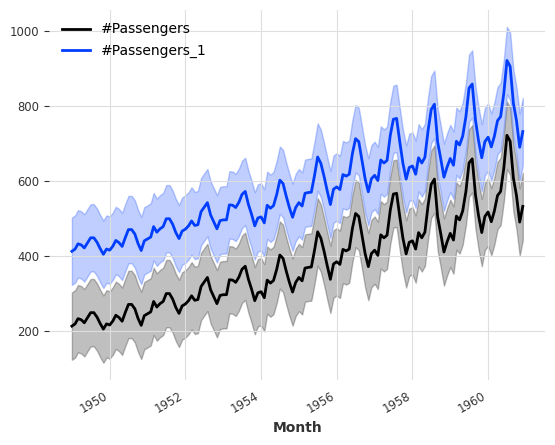

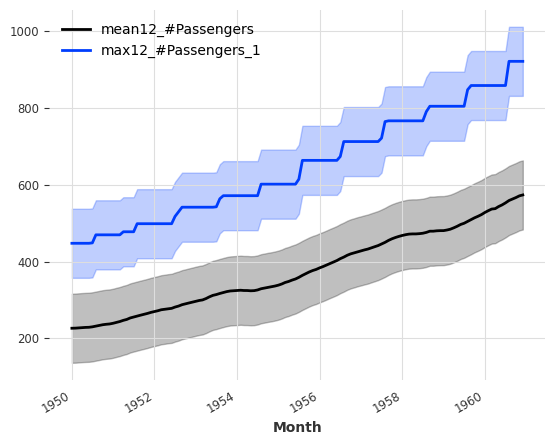

In [16]:
window_transf_dict = [
    {"function": "mean", "window": 12, "components": "#Passengers"},
    {"function": "max", "window": 12, "components": ["#Passengers_1"]},
]

transformed_stoch_series = stochastic_series.window_transform(
    window_transformations=window_transf_dict, keep_non_transformed=False
)

stochastic_series.plot()
transformed_stoch_series.plot(new_plot=True)

### User provided function
User can provide a function that expects a numpy array (default) and that returns a scalar output. The 'window' key is required here as well. The same behavior applies for selecting components and applying on stochastic series. <br>
The user can modify the input type to a pandas.Series by providing the key 'raw' in the transformation dictionary. 

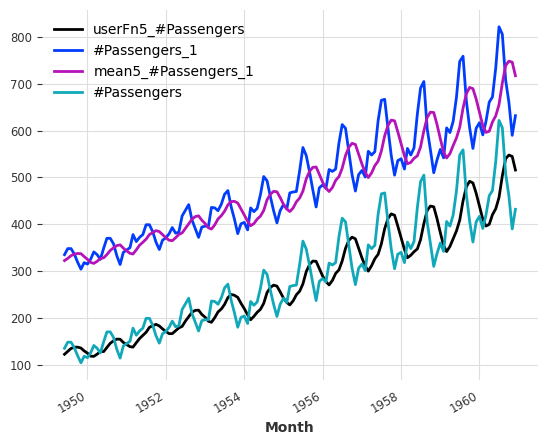

In [34]:
lifted_zscore = lambda x: ((x[-1] - x.mean()) / x.std()) + (
    x.mean()
)  # lifted for visibility ;)

window_transf_dict = [
    {"function": lifted_zscore, "window": 5, "components": ["#Passengers"]},
    {"function": "mean", "window": 5, "components": ["#Passengers_1"]},
]

transformed_m_series = multi_series.window_transform(
    window_transformations=window_transf_dict, keep_non_transformed=True
)

# multi_series.plot()
transformed_m_series.plot()

# changing the input type of the user function - advanced functionality
window_transf_dict = {"function": lifted_zscore, "window": 5, "raw": False}
# just set 'raw':False to switch from numpy.ndarray to pandas.Series

### Forecasting safe behavior and NA behavior
User can specify if the outputed transformation have to be guaranteed forecasting safe with an argument "forecasting_safe" (True/False, default: True) provided to TimeSeries.window_transform(). <br>
If True, it basically overrides some potentially conflicting configurations provided by the user. Namely, it removes the latest observation from the currently computed window (i.e., it sets the pandas.DataFrame.rolling "closed" parameter to "left") and makes sure that if user selects to fill NAs backwards with the first available window value computed, then the series is not filled backwards and NAs remain. <br>

By default, NAs are dropped (which assumes that NAs are only in the beginning of the transformed series). User can set the argument "treat_na" to: fill NAs with a given value or back fill NAs by specifying "bfill" (if no conflict with 'forecasting_safe') or leave NAs in the series. 
Nevertheless, other parametrisations are still possible, for example, to shrink the window progressively in order to guarantee non NAs in the transformed series without truncation. See section on "Flexible parametrization" below.  

In [2]:
# use a simpler series for easier checking
times = pd.date_range("20130101", "20130110")

series = TimeSeries.from_times_and_values(times, range(1, 11))

multi_series = series.stack(series + 10).stack(
    (series + 20).stack(series + 40), axis=2
)  # stochastic series

multi_series.pd_dataframe()  # updated the pd_dataframe() function to work with stochastic series

,0_s0,0_s1,0_1_s0,0_1_s1
time,,,,
2013-01-01,1.0,21.0,11.0,41.0
2013-01-02,2.0,22.0,12.0,42.0
2013-01-03,3.0,23.0,13.0,43.0
2013-01-04,4.0,24.0,14.0,44.0
2013-01-05,5.0,25.0,15.0,45.0
2013-01-06,6.0,26.0,16.0,46.0
2013-01-07,7.0,27.0,17.0,47.0
2013-01-08,8.0,28.0,18.0,48.0
2013-01-09,9.0,29.0,19.0,49.0


In [59]:
# default behavior : forecasting_safe = True (=> 'closed':'left', drop NAs)
window_transform_dict = {"function": "sum", "window": 3}
transformed_series = multi_series.window_transform(
    window_transformations=window_transform_dict, store_window_transformation=True
)
# stored window transformation as attribute, for debugging
print(
    "default behavior : forecasting_safe = True (=> 'closed':'left', drop NAs): \n",
    transformed_series.pd_dataframe(suppress_warnings=True),
)
print(
    multi_series.window_transformations
)  # check the final transformation configuration

default behavior : forecasting_safe = True (=> 'closed':'left', drop NAs): 
             sum3_0_s0  sum3_0_s1  sum3_0_1_s0  sum3_0_1_s1
time                                                      
2013-01-04        6.0       66.0         36.0        126.0
2013-01-05        9.0       69.0         39.0        129.0
2013-01-06       12.0       72.0         42.0        132.0
2013-01-07       15.0       75.0         45.0        135.0
2013-01-08       18.0       78.0         48.0        138.0
2013-01-09       21.0       81.0         51.0        141.0
2013-01-10       24.0       84.0         54.0        144.0
[{'function': 'sum', 'window': 3, 'closed': 'left'}]


In [60]:
# Enforcing default forecasting_safe= True: (replaces 'closed':'both' with 'left'), NAs are dropped
window_transform_dict = {
    "function": "sum",
    "window": 3,
    "closed": "both",
}  # no point is excluded
transformed_series = multi_series.window_transform(
    window_transformations=window_transform_dict, store_window_transformation=True
)
# stored window transformation as attribute, for debugging
print(
    "Enforcing default forecasting_safe= True: (replaces 'closed':'both' with 'left'), NAs are dropped \n",
    transformed_series.pd_dataframe(suppress_warnings=True),
)
print(
    multi_series.window_transformations
)  # forecasting_safe = True by default sets 'closed' to 'left'

Enforcing default forecasting_safe= True: (replaces 'closed':'both' with 'left'), NAs are dropped 
             sum3_0_s0  sum3_0_s1  sum3_0_1_s0  sum3_0_1_s1
time                                                      
2013-01-04        6.0       66.0         36.0        126.0
2013-01-05        9.0       69.0         39.0        129.0
2013-01-06       12.0       72.0         42.0        132.0
2013-01-07       15.0       75.0         45.0        135.0
2013-01-08       18.0       78.0         48.0        138.0
2013-01-09       21.0       81.0         51.0        141.0
2013-01-10       24.0       84.0         54.0        144.0
[{'function': 'sum', 'window': 3, 'closed': 'left'}]


In [61]:
# No conflict with forecasting_safe = False, NAs are kept by default
window_transform_dict = {
    "function": "sum",
    "window": 3,
    "closed": "both",
}  # 'both'= no point in the window is excluded
transformed_series = multi_series.window_transform(
    window_transformations=window_transform_dict,
    forecasting_safe=False,
    store_window_transformation=True,
)
# stored window transformation as attribute, for debugging
print(
    "No conflict with forecasting_safe = False, NAs are kept by default: \n",
    transformed_series.pd_dataframe(suppress_warnings=True),
)
print(
    multi_series.window_transformations
)  # forecasting_safe = False leaves 'closed' as provided

No conflict with forecasting_safe = False, NAs are kept by default: 
             sum3_0_s0  sum3_0_s1  sum3_0_1_s0  sum3_0_1_s1
time                                                      
2013-01-01        NaN        NaN          NaN          NaN
2013-01-02        NaN        NaN          NaN          NaN
2013-01-03        6.0       66.0         36.0        126.0
2013-01-04       10.0       90.0         50.0        170.0
2013-01-05       14.0       94.0         54.0        174.0
2013-01-06       18.0       98.0         58.0        178.0
2013-01-07       22.0      102.0         62.0        182.0
2013-01-08       26.0      106.0         66.0        186.0
2013-01-09       30.0      110.0         70.0        190.0
2013-01-10       34.0      114.0         74.0        194.0
[{'function': 'sum', 'window': 3, 'closed': 'both'}]


In [62]:
# If 'closed' is not specified, it is set to 'left' even if forecasting_safe = False
window_transform_dict = {"function": "sum", "window": 3}
transformed_series = multi_series.window_transform(
    window_transformations=window_transform_dict,
    forecasting_safe=False,
    store_window_transformation=True,
)
# stored window transformation as attribute, for debugging
print(
    "If 'closed' is not specified, it is set to 'left' even if forecasting_safe = False: \n",
    transformed_series.pd_dataframe(suppress_warnings=True),
)
print(multi_series.window_transformations)  #  default sets 'closed' to 'left'

If 'closed' is not specified, it is set to 'left' even if forecasting_safe = False: 
             sum3_0_s0  sum3_0_s1  sum3_0_1_s0  sum3_0_1_s1
time                                                      
2013-01-01        NaN        NaN          NaN          NaN
2013-01-02        NaN        NaN          NaN          NaN
2013-01-03        NaN        NaN          NaN          NaN
2013-01-04        6.0       66.0         36.0        126.0
2013-01-05        9.0       69.0         39.0        129.0
2013-01-06       12.0       72.0         42.0        132.0
2013-01-07       15.0       75.0         45.0        135.0
2013-01-08       18.0       78.0         48.0        138.0
2013-01-09       21.0       81.0         51.0        141.0
2013-01-10       24.0       84.0         54.0        144.0
[{'function': 'sum', 'window': 3, 'closed': 'left'}]


In [63]:
# If forecasting_safe=True (default) and treat_na = value, fill NAs with value, no conflict
window_transform_dict = {"function": "sum", "window": 3}
transformed_series = multi_series.window_transform(
    window_transformations=window_transform_dict, treat_na=100
)

print(
    "If forecasting_safe=True (default) and treat_na = value, fill NAs with value, no conflict: \n",
    transformed_series.pd_dataframe(suppress_warnings=True),
)

If forecasting_safe and treat_na = value, fill NAs with value, no conflict: 
             sum3_0_s0  sum3_0_s1  sum3_0_1_s0  sum3_0_1_s1
time                                                      
2013-01-01      100.0      100.0        100.0        100.0
2013-01-02      100.0      100.0        100.0        100.0
2013-01-03      100.0      100.0        100.0        100.0
2013-01-04        6.0       66.0         36.0        126.0
2013-01-05        9.0       69.0         39.0        129.0
2013-01-06       12.0       72.0         42.0        132.0
2013-01-07       15.0       75.0         45.0        135.0
2013-01-08       18.0       78.0         48.0        138.0
2013-01-09       21.0       81.0         51.0        141.0
2013-01-10       24.0       84.0         54.0        144.0


In [65]:
# If forecasting_safe=True (default) and treat_na = 'bfill', conflict => drops NA instead
window_transform_dict = {"function": "sum", "window": 3}
transformed_series = multi_series.window_transform(
    window_transformations=window_transform_dict, treat_na="bfill"
)

print(
    "If forecasting_safe=True (default) and treat_na = 'bfill', conflict => drops NA instead : \n",
    transformed_series.pd_dataframe(suppress_warnings=True),
)

If forecasting_safe=True (default) and treat_na = 'bfill', conflict => drops NA instead : 
             sum3_0_s0  sum3_0_s1  sum3_0_1_s0  sum3_0_1_s1
time                                                      
2013-01-04        6.0       66.0         36.0        126.0
2013-01-05        9.0       69.0         39.0        129.0
2013-01-06       12.0       72.0         42.0        132.0
2013-01-07       15.0       75.0         45.0        135.0
2013-01-08       18.0       78.0         48.0        138.0
2013-01-09       21.0       81.0         51.0        141.0
2013-01-10       24.0       84.0         54.0        144.0


In [68]:
# If forecasting_safe=False, no conflicts : user can 'dropna', 'bfill' or leave NAs
window_transform_dict = {"function": "sum", "window": 3}
transformed_series = multi_series.window_transform(
    window_transformations=window_transform_dict,
    forecasting_safe=False,
    treat_na="bfill",
)

print(
    "If forecasting_safe=False, no conflicts : user can 'bfill': \n",
    transformed_series.pd_dataframe(suppress_warnings=True),
)
print("\n")

transformed_series = multi_series.window_transform(
    window_transformations=window_transform_dict,
    forecasting_safe=False,
    treat_na="dropna",
)

print(
    "If forecasting_safe=False, no conflicts : user can'dropna': \n",
    transformed_series.pd_dataframe(suppress_warnings=True),
)
print("\n")

transformed_series = multi_series.window_transform(
    window_transformations=window_transform_dict,
    forecasting_safe=False,
)

print(
    "If forecasting_safe=False, no conflicts : user can leave NAs: \n",
    transformed_series.pd_dataframe(suppress_warnings=True),
)

If forecasting_safe=False, no conflicts : user can 'bfill': 
             sum3_0_s0  sum3_0_s1  sum3_0_1_s0  sum3_0_1_s1
time                                                      
2013-01-01        6.0       66.0         36.0        126.0
2013-01-02        6.0       66.0         36.0        126.0
2013-01-03        6.0       66.0         36.0        126.0
2013-01-04        6.0       66.0         36.0        126.0
2013-01-05        9.0       69.0         39.0        129.0
2013-01-06       12.0       72.0         42.0        132.0
2013-01-07       15.0       75.0         45.0        135.0
2013-01-08       18.0       78.0         48.0        138.0
2013-01-09       21.0       81.0         51.0        141.0
2013-01-10       24.0       84.0         54.0        144.0


If forecasting_safe=False, no conflicts : user can'dropna': 
             sum3_0_s0  sum3_0_s1  sum3_0_1_s0  sum3_0_1_s1
time                                                      
2013-01-04        6.0       66.0         36.0   

### Flexible parametrization

#### NA behavior
To allow for the window to shrink with the remaining number of observations in the series, hence keep the series length unchanged and unfilled with NAs, user can add the following "min_periods" : 0 to the transformation dictionary.
"min_periods" is a pandas.DataFrame.rolling argument. <br>
Note that the "min_periods":0 behavior is not the same for all functions, for example with 'mean', there would still be one NA at the beginning of the series. The issue here is that 'closed':'left' could be enforced, hence not allowing to use the only available value. So here there might be a conflict with forecasting_safe behavior. 

In [10]:
window_transform_dict = {
    "function": "mean",
    "window": 3,
    "min_periods": 0,
    "closed": "both",
}
transformed_series = multi_series.window_transform(
    window_transformations=window_transform_dict, forecasting_safe=False
)
# if forecasting_safe = True (default), there would be one NA in the beginning of the series that would be dropped
# I think we need to decide here what is the default behavior for 'closed' and dropping/keeping NAs

print(
    "If forecasting_safe=True (default), when 'min_periods':0 is specifed => no NAs and same series length: head of the series is filled with a 0 value instead of NAs \n",
    transformed_series.pd_dataframe(suppress_warnings=True),
)

If forecasting_safe=True (default), when 'min_periods':0 is specifed => no NAs and same series length: head of the series is filled with a 0 value instead of NAs 
             mean3_0_1_s0  mean3_0_1_s1  mean3_0_s0  mean3_0_s1
time                                                          
2013-01-01           1.0          21.0        11.0        41.0
2013-01-02           1.5          21.5        11.5        41.5
2013-01-03           2.0          22.0        12.0        42.0
2013-01-04           2.5          22.5        12.5        42.5
2013-01-05           3.5          23.5        13.5        43.5
2013-01-06           4.5          24.5        14.5        44.5
2013-01-07           5.5          25.5        15.5        45.5
2013-01-08           6.5          26.5        16.5        46.5
2013-01-09           7.5          27.5        17.5        47.5
2013-01-10           8.5          28.5        18.5        48.5


#### Passing parameters to the underlying functions 
Any argument that needs to be passed to the underlying built-in or user defined functions can be provided as "key:value" pairs in the transformation dictionnary. 
Some mandatory parameters are checked by default (e.g., quantile function below) mandatory arguments are dictated by required positional arguments of the underlying functions. Extra tuning parameters are left to the user to provide and choose. 

In [76]:
# Error : when selecting 'function':'quantile' and not providing the quantile value
window_transform_dict = {"function": "quantile", "window": 3}
transformed_series = multi_series.window_transform(
    window_transformations=window_transform_dict
)

ValueError: `window_transformation` dictionary at index 0 must contain at least the following keys ['window', 'quantile'] for built-in rolling.quantile.


ValueError: `window_transformation` dictionary at index 0 must contain at least the following keys ['window', 'quantile'] for built-in rolling.quantile.

In [78]:
# providing a 'step' value, a step value larger than 1 changes the frequency of the series
# We don't call it stride, because 'step' is the name of the argument for pandas.DataFrame.rolling
window_transform_dict = {"function": "sum", "window": 3, "step": 2}
transformed_series = multi_series.window_transform(
    window_transformations=window_transform_dict, forecasting_safe=False
)
print(
    "providing a 'step' value, a step value larger than 1 changes the frequency of the series: \n",
    transformed_series.pd_dataframe(suppress_warnings=True),
)

providing a 'step' value, a step value larger than 1 changes the frequency of the series             sum3_0_s0  sum3_0_s1  sum3_0_1_s0  sum3_0_1_s1
time                                                      
2013-01-01        NaN        NaN          NaN          NaN
2013-01-03        NaN        NaN          NaN          NaN
2013-01-05        9.0       69.0         39.0        129.0
2013-01-07       15.0       75.0         45.0        135.0
2013-01-09       21.0       81.0         51.0        141.0


### Aligning a target series and the transformed series indices 
User can provide a series in the "target" argument in order to align/interset the time indeces of the target with the transformed series. The truncated series is a new TimeSeries object, the original target is preserved. 

In [80]:
window_transform_dict = {"function": "sum", "window": 3}
transformed_series, truncated_target = multi_series.window_transform(
    window_transformations=window_transform_dict, target=multi_series
)
print("original series : \n", multi_series.pd_dataframe(suppress_warnings=True))
print("\n")
print(
    "transformed series : \n", transformed_series.pd_dataframe(suppress_warnings=True)
)
print("\n")
print("truncated series : \n", truncated_target.pd_dataframe(suppress_warnings=True))

original series : 
             0_s0  0_s1  0_1_s0  0_1_s1
time                                  
2013-01-01   1.0  21.0    11.0    41.0
2013-01-02   2.0  22.0    12.0    42.0
2013-01-03   3.0  23.0    13.0    43.0
2013-01-04   4.0  24.0    14.0    44.0
2013-01-05   5.0  25.0    15.0    45.0
2013-01-06   6.0  26.0    16.0    46.0
2013-01-07   7.0  27.0    17.0    47.0
2013-01-08   8.0  28.0    18.0    48.0
2013-01-09   9.0  29.0    19.0    49.0
2013-01-10  10.0  30.0    20.0    50.0


transformed series : 
             sum3_0_s0  sum3_0_s1  sum3_0_1_s0  sum3_0_1_s1
time                                                      
2013-01-04        6.0       66.0         36.0        126.0
2013-01-05        9.0       69.0         39.0        129.0
2013-01-06       12.0       72.0         42.0        132.0
2013-01-07       15.0       75.0         45.0        135.0
2013-01-08       18.0       78.0         48.0        138.0
2013-01-09       21.0       81.0         51.0        141.0
2013-01-10     

## Creating a ForecastingWindowTransformer
With a ForecastingWindowTransformer user can provide a sequence of TimeSeries and can choose to apply different transformations to different series (and different compoenents in those series). 

In [11]:
from darts.dataprocessing.transformers.window_transformer import (
    ForecastingWindowTransformer,
)

times = pd.date_range("20130101", "20130110")

series_1 = TimeSeries.from_times_and_values(times, range(1, 11))
series_2 = TimeSeries.from_times_and_values(times, range(1, 11)) * 2

multi_series_1 = series.stack(series + 10).stack(
    (series + 20).stack(series + 40), axis=2
)  # stochastic series
multi_series_2 = (series.stack(series + 10).stack((series + 20).stack(series + 40))) * 5

all_series = [series_1, series_2, multi_series_1, multi_series_2]

transformed_series is a list of length =  4
series_1 transformations: [{'function': 'sum', 'window': 3, 'closed': 'left'}]
series_2 transformations: [{'function': 'sum', 'window': 3, 'closed': 'left'}]
multi_series_1 transformations: [{'function': 'sum', 'window': 3, 'closed': 'left'}]
multi_series_2 transformations: [{'function': 'sum', 'window': 3, 'closed': 'left'}]


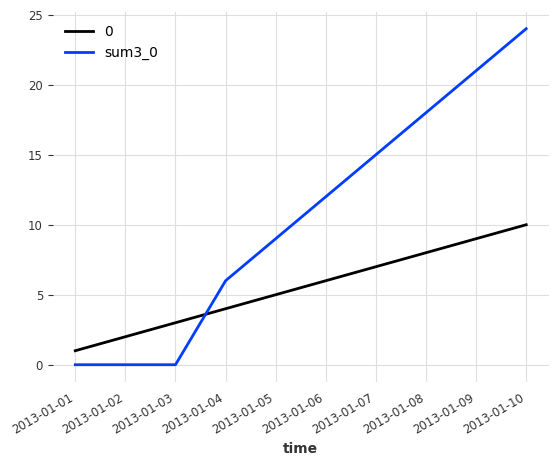

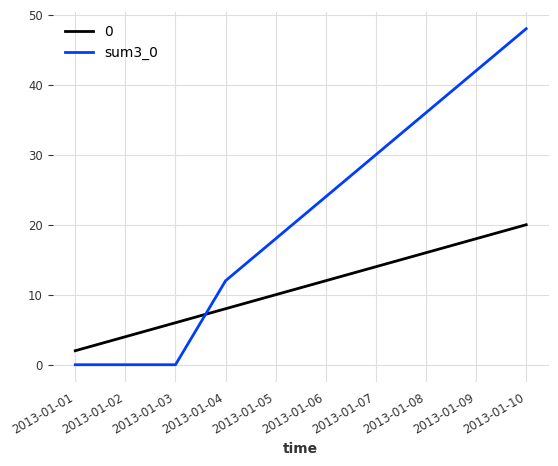

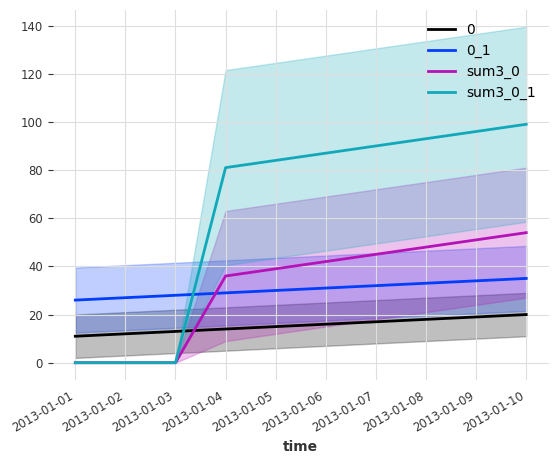

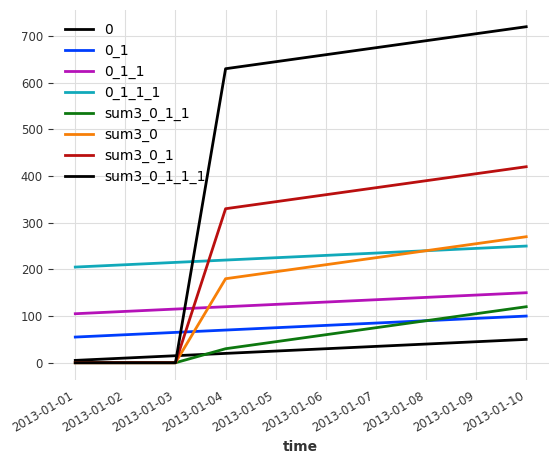

In [117]:
# same function will apply to all series and all their components
window_transformations_1 = {"function": "sum", "window": 3}

transformer_1 = ForecastingWindowTransformer(
    window_transformations=window_transformations_1
)
transformed_series_1 = transformer_1.transform(
    all_series,
    treat_na=0,
    store_window_transformation=True,
)
# keep_non_transformed = True)

print("transformed_series is a list of length = ", len(transformed_series))

all_series[0].plot()
transformed_series_1[0].plot()
print("series_1 transformations:", series_1.window_transformations)

all_series[1].plot(new_plot=True)
transformed_series_1[1].plot()
print("series_2 transformations:", series_2.window_transformations)

all_series[2].plot(new_plot=True)
transformed_series_1[2].plot()
print("multi_series_1 transformations:", multi_series_1.window_transformations)

all_series[3].plot(new_plot=True)
transformed_series_1[3].plot()
print("multi_series_2 transformations:", multi_series_2.window_transformations)

# feel free to change the parameters passed to transform() in order to select how to treat NAs, keep_non_transformed, etc.

transformed_series is a list of length =  4
series_1 transformations: [{'function': 'sum', 'window': 3, 'min_periods': 0, 'closed': 'left'}]
multi_series_1 transformations: [{'function': 'sum', 'window': 3, 'min_periods': 0, 'closed': 'left'}]
series_2 transformations: [{'function': 'mean', 'window': 3, 'min_periods': 0, 'closed': 'left'}]
component   mean3_0
time               
2013-01-02      2.0
2013-01-03      3.0
2013-01-04      4.0
2013-01-05      6.0
2013-01-06      8.0
2013-01-07     10.0
2013-01-08     12.0
2013-01-09     14.0
2013-01-10     16.0
multi_series_2 transformations: [{'function': 'mean', 'window': 3, 'min_periods': 0, 'closed': 'left'}]


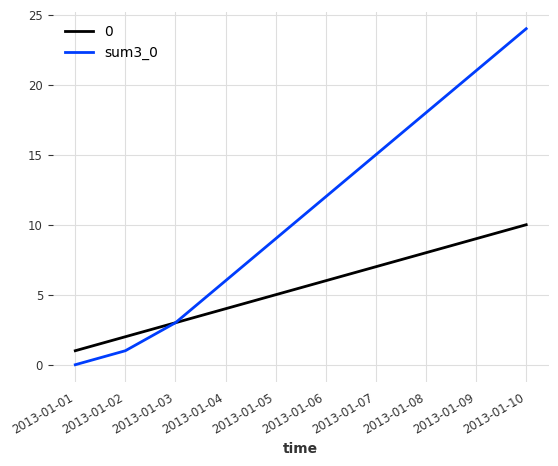

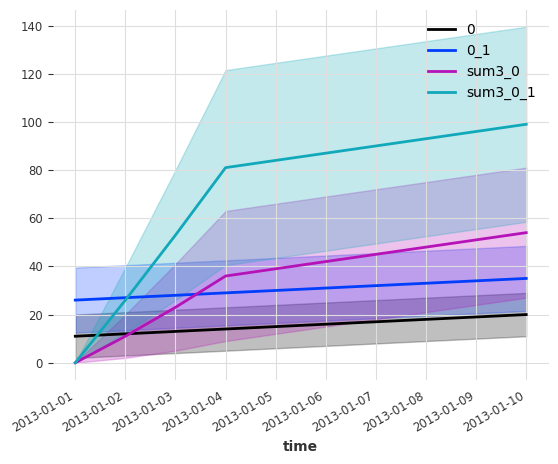

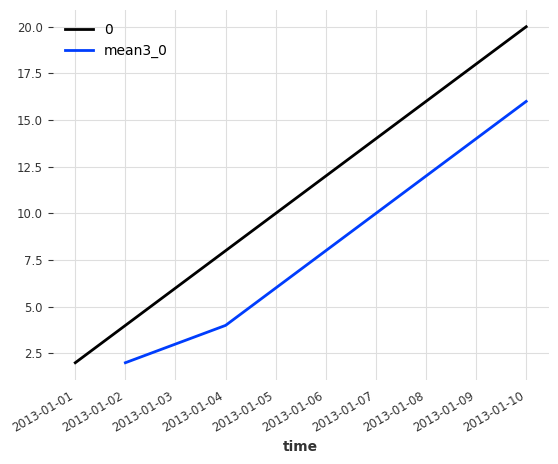

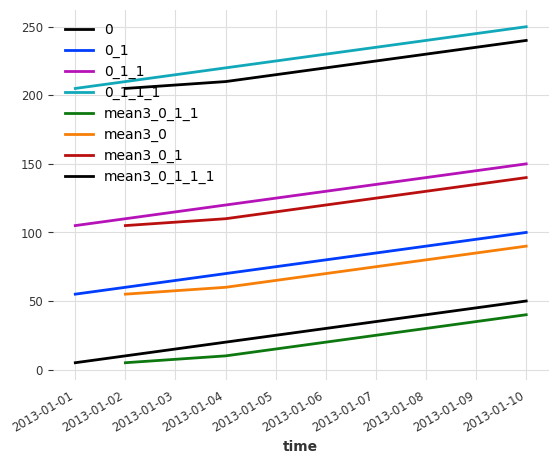

In [140]:
# apply to all components in series 0 and 2 (index of the series in the sequence)
window_transformations_2 = [
    {"function": "sum", "window": 3, "series_id": [0, 2], "min_periods": 0},
    {"function": "mean", "window": 3, "series_id": [1, 3], "min_periods": 0},
]

transformer_2 = ForecastingWindowTransformer(
    window_transformations=window_transformations_2
)
transformed_series_2 = transformer_2.transform(
    all_series,
    store_window_transformation=True,
)
# keep_non_transformed = True)

print("transformed_series is a list of length = ", len(transformed_series_2))

all_series[0].plot()
transformed_series_2[0].plot()
print("series_1 transformations:", series_1.window_transformations)

all_series[2].plot(new_plot=True)
transformed_series_2[1].plot()
print("multi_series_1 transformations:", multi_series_1.window_transformations)

all_series[1].plot(new_plot=True)
transformed_series_2[2].plot()
print("series_2 transformations:", series_2.window_transformations)
print(transformed_series_2[2].pd_dataframe(suppress_warnings=True))

all_series[3].plot(new_plot=True)
transformed_series_2[3].plot()
print("multi_series_2 transformations:", multi_series_2.window_transformations)

# note here that the series indices in the original sequence do not refer to their index in the transformed sequences
# the order in the transformed sequence is 0,2,1,3 [as provided in the transformation dictionary]

transformed_series is a list of length =  2


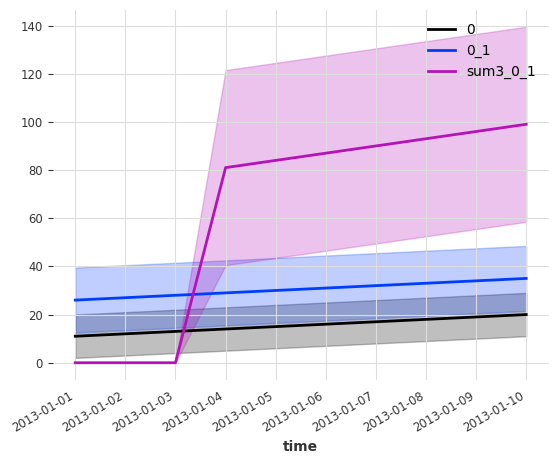

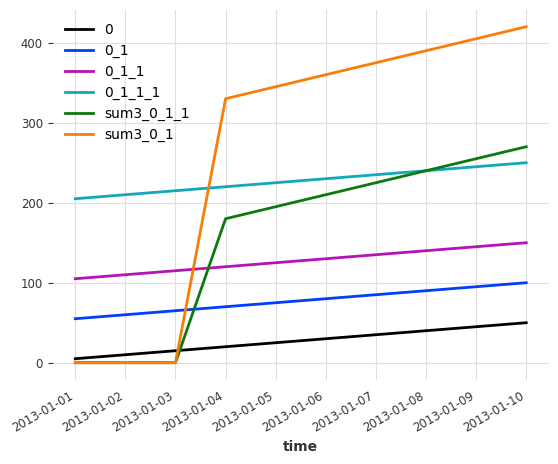

In [114]:
# apply to specific components in specific series
window_transformations_3 = {
    "function": "sum",
    "window": 3,
    "series_id": [2, 3],
    "components": [["0_1"], ["0_1", "0_1_1"]],
}

transformer_3 = ForecastingWindowTransformer(
    window_transformations=window_transformations_3
)
transformed_series_3 = transformer_3.transform(
    all_series,
    treat_na=0,
)  # keep_non_transformed = True)

print("transformed_series is a list of length = ", len(transformed_series_3))

all_series[2].plot()
transformed_series_3[0].plot()

all_series[3].plot(new_plot=True)
transformed_series_3[1].plot()

# only 2 series in the sequence were requested to be transformed

## Calling a window transformer in pipeline

In [12]:
from darts.dataprocessing.pipeline import Pipeline
from darts.dataprocessing.transformers import Mapper

window_transformations = [
    {"function": "sum", "window": 3, "series_id": [0, 2], "min_periods": 0},
    {"function": "mean", "window": 3, "series_id": [1, 3], "min_periods": 0},
]


def times_five(x):
    return x * 5


mapper = Mapper(fn=times_five)

window_transformer = ForecastingWindowTransformer(
    window_transformations=window_transformations
)

pipeline = Pipeline([mapper, window_transformer])

transformed_series = pipeline.fit_transform(all_series)  # , treat_na = 0)
# the pipeline does not allow passing kwargs, so might cause problems for flexiblity ?!

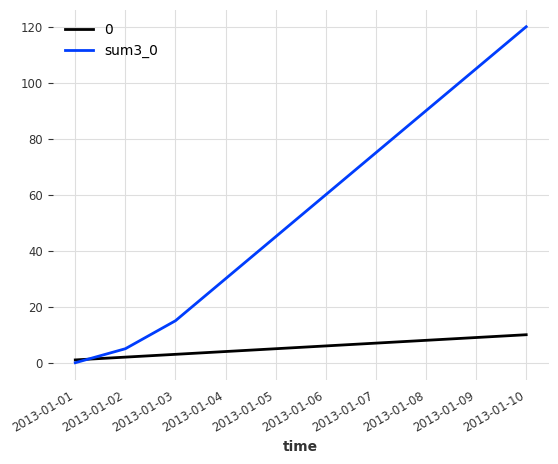

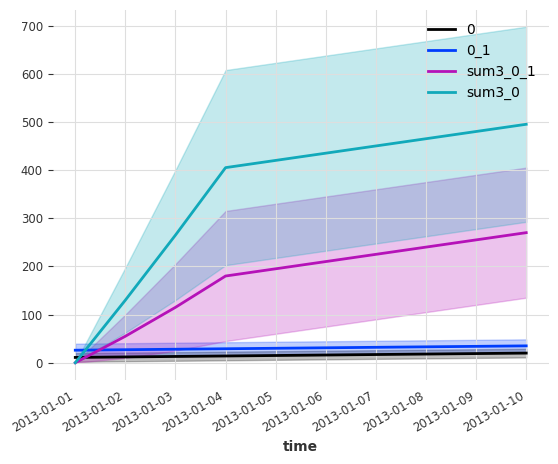

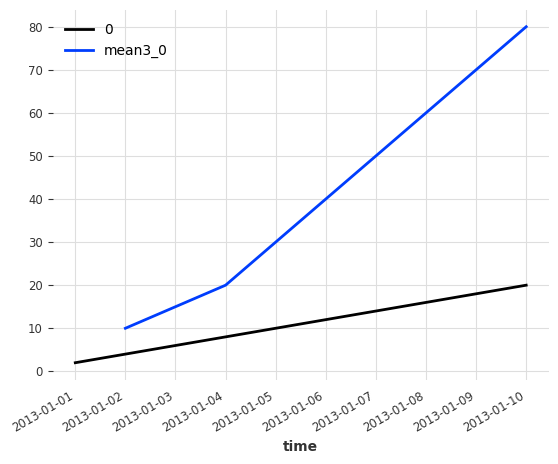

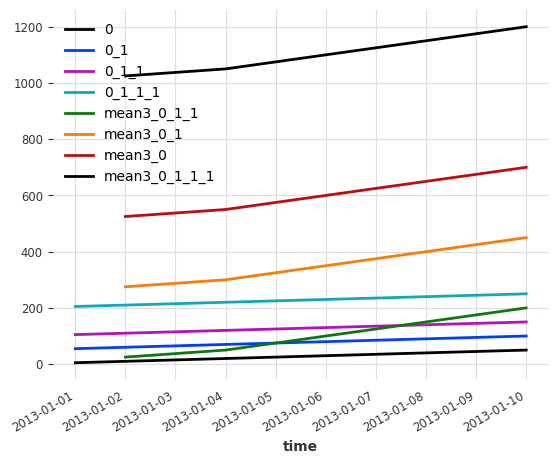

In [13]:
all_series[0].plot()
transformed_series[0].plot()

all_series[2].plot(new_plot=True)
transformed_series[1].plot()


all_series[1].plot(new_plot=True)
transformed_series[2].plot()


all_series[3].plot(new_plot=True)
transformed_series[3].plot()

# why is the mean series not starting at the same point, despite the min_periods:0 ?
# check note about "min_periods" for "mean" in "Flexible parametrization / NA behavior" section above.

# Congratulations, you made it to the end of this notebook
# You earn the badge of patience :) 
# Thank you for reading through